In [1]:
%matplotlib ipympl

import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [2]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [3]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [4]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [5]:
def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.3}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in [1, -1]:
            positive_stark_shift = (label * positive_field_plate) > 0
            if positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

In [6]:
def ah_height_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"]
    rf_avg = transmissions_avg["rf"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    off_resonant_index = np.argmax(np.abs(detunings) > 0)
    on_resonant_index = 1 - off_resonant_index
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        heights = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
    else:
        raise NotImplementedError()
    return heights

In [256]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    headers = []
    for data_number in data_numbers:
        transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
        if method == "auto":
            detunings_len = len(headers_single["detunings"])
            if detunings_len > 4:
                method = "fit"
            else:
                method = "ratio"
        if method == "fit":
            try:
                fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
            except RuntimeError as e:
                print(f"Fitting error for data number #{data_number}:")
                raise e
            for label in fits:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                rf_heights[label].append(fits[label]["rf"].results["a"] / fits[label]["rf"].results["c"])
                antihole_heights[label].append(fits[label]["ah"].results["a"] / fits[label]["ah"].results["c"])
        elif method == "ratio":
            heights = ah_height_from_data(transmissions_avg, monitors_avg, headers_single)
            for label in heights:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                rf_heights[label].append(heights[label]["rf"])
                antihole_heights[label].append(heights[label]["ah"])
        headers.append(headers_single)
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
    return rf_heights, antihole_heights, headers

In [257]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

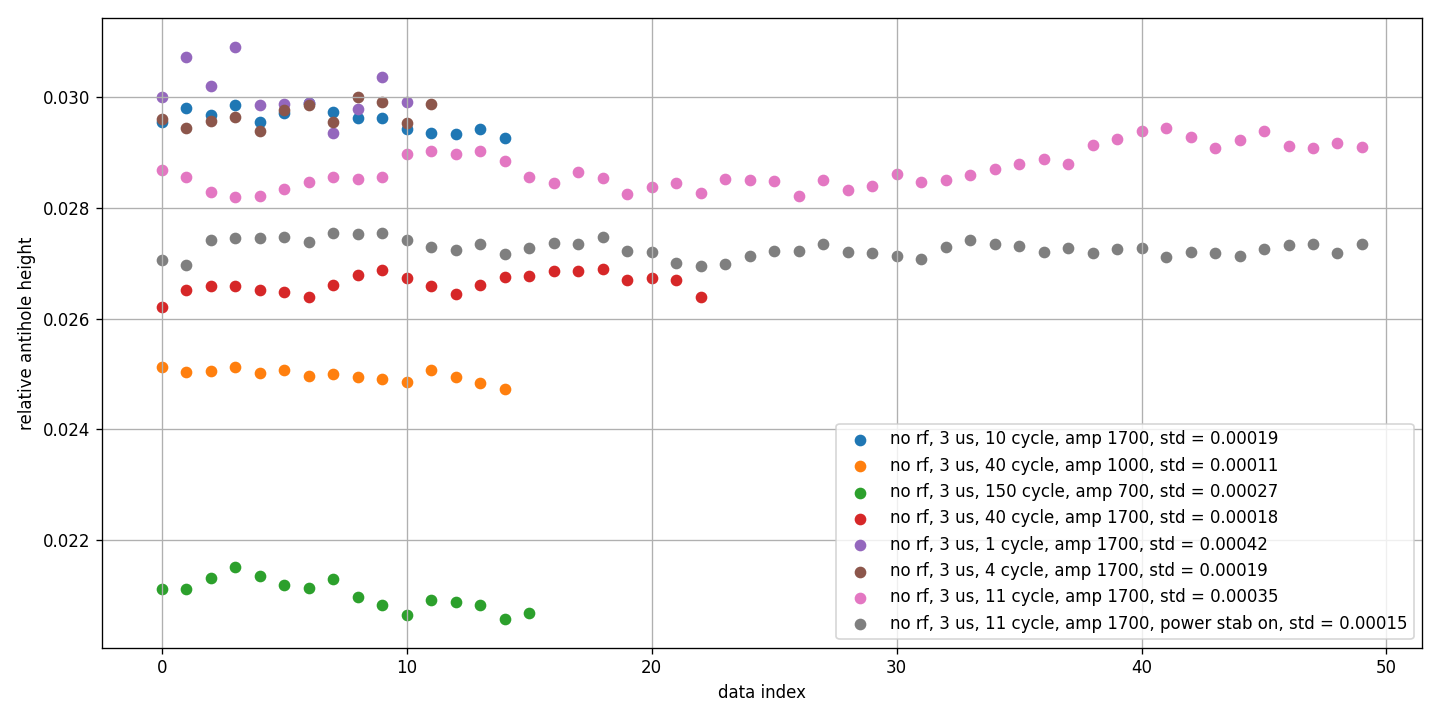

In [279]:
data = {
    #"no rf": (103390, 103750), # weekend run
    
    #"no rf, 2 points, 10 us, 1 cycle": (107016, 107037),
    #"no rf, 20 points, 10 us, 1 cycle": (107038, 107060),
    #"no rf, 2 points, 10 us, 5 cycles": (107061, 107080),
    #"no rf, 20 points, 10 us, 5 cycles": (107110, 107140),
    #"no rf, 2 points, 5 us, 10 cycles": (107141, 107164),
    #"no rf, 2 points, 5 us, 20 cycles": (107165, 107180),
    
    #"no rf, 2 points, 50 us, 1 cycle": (107181, 107195),
    #"no rf, 2 points, 25 us, 1 cycle": (107196, 107198),
    #"no rf, 2 points, 12 us, 1 cycle": (107199, 107201),
    #"no rf, 2 points, 6 us, 1 cycle": (107202, 107204),
    #"no rf, 2 points, 3 us, 1 cycle": (107205, 107207),
    #"no rf, 2 points, 100 us, 1 cycle": (107208, 107210),

    #"no rf, no chasm probes, 5 us, 10 cycles": (107211, 107265),
    
    #"no rf, 5 us, 10 cycles, power stab off": (108234, 108350),
    #"no rf, 5 us, 10 cycles, power stab on": (108379, 108510),
    
    #"no rf, no ah, 5 us, 10 cycles, power stab on": (108512, 108611),
    
    #"no rf, no ah, 5 us, 1 cycle, power stab on": (108612, 108658),
    #"no rf, 5 us, 1 cycle, power stab on": (108674, 108718),
    #"no rf, no ah, 100 us, 1 cycle, power stab on": (108719, 108739),
    #"no rf, no ah, 1000 us, 1 cycle, power stab on": (108740, 108758),
    #"no rf, no ah, 10000 us, 1 cycle, power stab on": (108759, 108777),
    #"no rf, no ah, 10 us, 1 cycle, power stab on": (108778, 108798),
    #"no rf, no ah, 3 us, 1 cycle, power stab on": (108799, 108822),
    #"no rf, no ah, 3 us, 30 cycle, power stab on": (108823, 108841),
    #"no rf, no ah, 3 us, 300 cycle, power stab on": (108842, 108873),
    #"no rf, no ah, 3 us, 300 cycle, power stab off": (108876, 108918),
    
    #"no rf, no ah, 3 us, 10 cycle, amp 1700": (108976, 108999),  # 1.18
    #"no rf, no ah, 3 us, 10 cycle, amp 1000": (109000, 109026),  # 0.254
    #"no rf, no ah, 3 us, 10 cycle, amp 700": (109027, 109041),  # 0.076
    #"no rf, no ah, 3 us, 40 cycle, amp 1000": (109063, 109082),  # 0.254
    #"no rf, no ah, 3 us, 150 cycle, amp 700": (109042, 109062),  # 0.076
    "no rf, 3 us, 10 cycle, amp 1700": (109135, 109149),
    "no rf, 3 us, 40 cycle, amp 1000": (109098, 109112),
    "no rf, 3 us, 150 cycle, amp 700": (109150, 109165),
    "no rf, 3 us, 40 cycle, amp 1700": (109166, 109188),
    #"no rf, long ah, 3 us, 40 cycle, amp 1700": (109189, 109204),
    "no rf, 3 us, 1 cycle, amp 1700": (109205, 109215),
    "no rf, 3 us, 4 cycle, amp 1700": (109217, 109228),
    "no rf, 3 us, 11 cycle, amp 1700": (109229, 109278),
    "no rf, 3 us, 11 cycle, amp 1700, power stab on": (109279, 109328),
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    rf_heights, ah_heights, headers = rf_spectroscopy_ah_ratio(data_list)
    #xs = [header["params"]["rf"]["detuning"].to("kHz").magnitude for header in headers]
    xs = [header["data_info"]["data_number"] for header in headers]
    xs = [kk - xs[0] for kk in xs]
    ys = ah_heights[0]
    ax.scatter(xs, ys, label=label + f", std = {np.std(ys):.2g}")
    
#ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_xlabel("data index")
#ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.set_ylabel("relative antihole height")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [280]:
data, headers = get_experiment_data(109402)

In [281]:
detunings_MHz = headers["detunings"].to("MHz").magnitude
transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])

In [282]:
plt_monitor = False
use_positive = None

antihole_avg = transmissions_avg["antihole"]
rf_avg = transmissions_avg["rf"]
if "chasm" in transmissions_avg:
    chasm_avg = transmissions_avg["chasm"]
    antihole_normalized = antihole_avg / chasm_avg
    rf_normalized = rf_avg / chasm_avg
else:
    antihole_normalized = antihole_avg
    rf_normalized = rf_avg

if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
ax.scatter(detunings_MHz[mask], antihole_normalized, label="antihole / chasm", color="C1")
ax.scatter(detunings_MHz[mask], rf_normalized, label="rf / chasm", color="C2")

xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")
rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_normalized, p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.all_results_str())
print()
print(rf_fit.all_results_str())

KeyError: 'rf'